# Linear and Polynomial Regression

### Table of Contents

* [Linear Regression](#LinearRegression)
    * [closed form solution](#close_form)
    * [Pseudo Inverse solution (scipy)](#pseudo_inverse_solution)
    * [Batch Gradient Descent](#batch_gd)
    * [Stochastic Gradient Descent](#sgd)
    
* [Polynomial Regression](#polynomial_regression)
    * [Learning curves](#learning_curves)
* [Regularization](#regularization)
    * [Ridge Lasso ElasticNet](#ridge_lasso_elastic)
    * [Early Stopping](#early_stopping)
    

## Imports

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# inline plot 
%matplotlib inline  
# default figure size 
matplotlib.rcParams['figure.figsize'] = (20, 10)
# to make our sets reproducible 
np.random.seed(42) 
%config Completer.use_jedi = False

In [2]:
from typing import List, Dict, Tuple, Union, Optional, Callable

# Linear Regression <a class="anchor" id="LinearRegression"></a>

### Data generation <a class="anchor" id="linear_data_generation"></a>

$$Y = 3 \cdot X + 4 + \epsilon \\ \epsilon \sim  \mathcal{N}(0,1)$$

In [4]:
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

### Closed form analytical solution <a class="anchor" id="close_form"></a>

In [5]:
X_b = np.c_[np.ones((100, 1)), X] # add x0 = 1 (intercept) to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[3.86501051],
       [3.13916179]])


features: 
[[ 1. -1.]
 [ 1.  0.]
 [ 1.  2.]
 [ 1.  5.]]
predictions:
[[ 0.72584873]
 [ 3.86501051]
 [10.14333409]
 [19.56081945]]



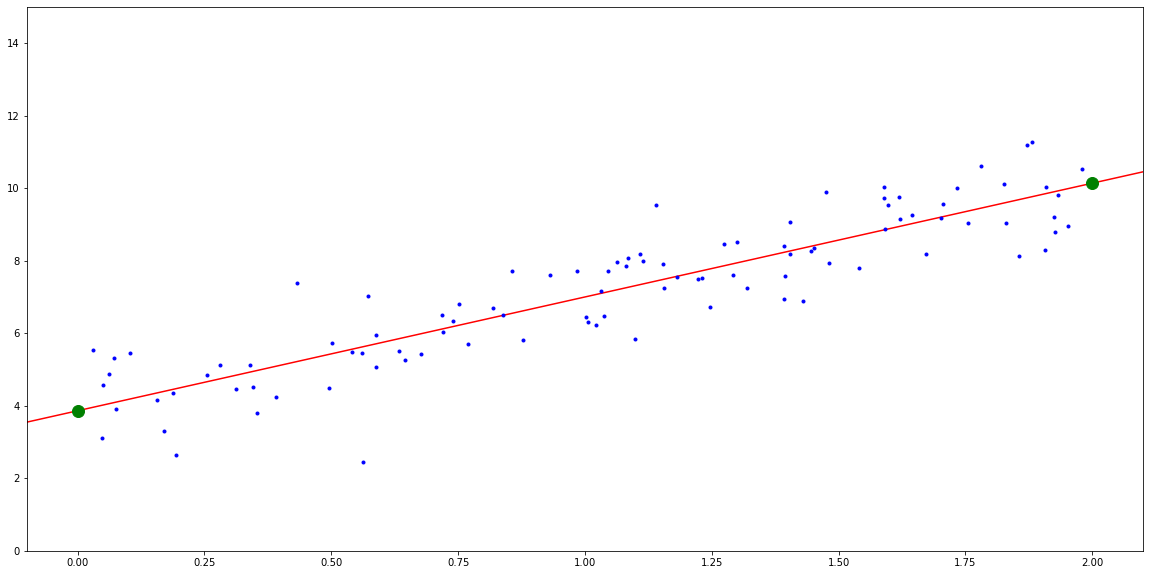

In [6]:
# predict for 3 data points
X_new = np.array([[-1], [0], [2], [5]])
y_new = 4 + 3 * X_new + np.random.randn(4, 1)

# add x0 = 1 to each instance - intercept dummy feature
X_new_b = np.c_[np.ones((X_new.shape[0], 1)), X_new] 
y_predict = X_new_b.dot(theta_best)

print(f'''
features: 
{X_new_b}
predictions:
{y_predict}
''')

plt.plot(X_new, y_predict, "r-")
plt.plot(X_new, y_predict, "go", markersize=12)
plt.plot(X, y, "b.")
plt.axis([-.1, 2.1, 0, 15])
plt.show()

## Linear Regreesion Using ScikitLearn <a class="anchor" id="scikit"></a>

In [7]:
from sklearn.linear_model import LinearRegression
# include intercept
lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([3.86501051]), array([[3.13916179]]))

In [8]:
# predictions
lin_reg.predict(X_new)

array([[ 0.72584873],
       [ 3.86501051],
       [10.14333409],
       [19.56081945]])

## Linear Regression using scipy <a class="anchor" id="pseudo_inverse_solution"></a>

In [9]:
from scipy.linalg import lstsq
# solves using SVD
theta_best_svd, residuals, rank, s = lstsq(X_b, y, cond=1e-6)

In [18]:
print(f"""
solution: {np.reshape(theta_best_svd, (-1,))}
sum residuals: {residuals}
rank of X^TX matrix: {rank}
singular values of X^TX: {s} 
""")


solution: [3.86501051 3.13916179]
sum residuals: [79.48178989]
rank of X^TX matrix: 2
singular values of X^TX: [15.17147422  3.77357366] 



## Solving using the pseudo inverse <a class="anchor" id="pseudo_inverse"></a>

In [19]:
# same solution as in scipy 
np.linalg.pinv(X_b).dot(y)

array([[3.86501051],
       [3.13916179]])

## Linear regression using batch gradient descent  <a class="anchor" id="batch_gd"></a>

In [20]:
# learning rate
eta = 0.1  
# number of iterations 
n_iterations = 1000

m = X_b.shape[0]

# random initialization
theta = np.random.randn(2,1)  
        
for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients
print(f"""
solution: {theta.ravel()}
""")
print('\n'.join([f'prediction for {x_i} : {x_i.dot(theta)[0]}'  for x_i in X_new_b]))


solution: [3.86501051 3.13916179]

prediction for [ 1. -1.] : 0.7258487253110419
prediction for [1. 0.] : 3.865010512555871
prediction for [1. 2.] : 10.14333408704553
prediction for [1. 5.] : 19.560819448780016


### Converging with different learning rates 

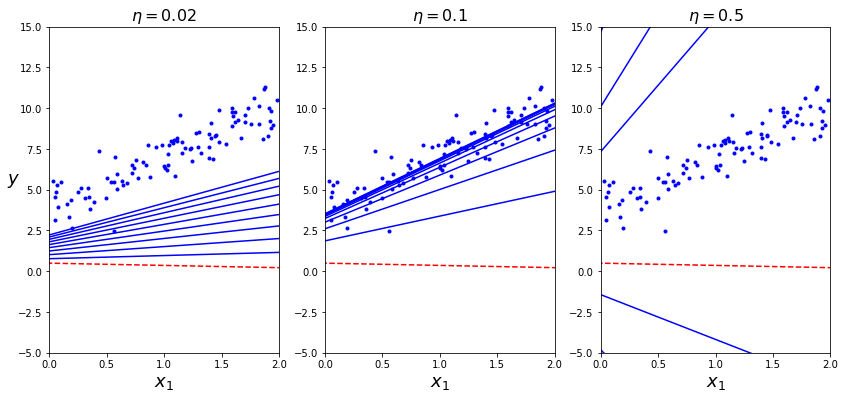

In [21]:

def plot_gradient_descent(theta, eta:float, theta_path=None, n_iterations: int = 1000):
    m = len(X_b)
    plt.plot(X, y, "b.")
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        # gradient is computed sing all datapoints
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        # add new 
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, -5, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)
    
theta_path_bgd = []

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(14,6))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)


### Learning rate schedueling (custom)

array([[3.90521218],
       [3.15642095]])

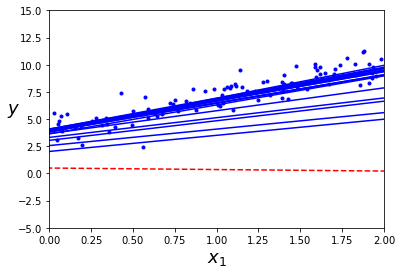

In [24]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    # decreases from 1/10 towards zero as a function of the step
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization
plt.figure(figsize=(6,4))
# number of times to go over the entire trainin set 
for epoch in range(n_epochs):
    # go over samples (per epoch)
    for i in range(m):
        if epoch == 0 and i < 20:                     
            y_predict = X_new_b.dot(theta)            
            style = "b-" if i > 0 else "r--"          
            plt.plot(X_new, y_predict, style)         
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                  

plt.plot(X, y, "b.")                                  
plt.xlabel("$x_1$", fontsize=18)                      
plt.ylabel("$y$", rotation=0, fontsize=18)           
plt.axis([0, 2, -5, 15])                               
theta


## Stochastic Gradient Descent using scikit  <a class="anchor" id="sgd"></a>

In [25]:
# SGD stands for Stochastic Gradient Descent: the gradient of the loss is
# estimated each sample at a time and the model is updated along the way with
# a decreasing strength schedule (aka learning rate).

from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, fit_intercept=True)
sgd_reg.fit(X, y.ravel())
sgd_reg.intercept_, sgd_reg.coef_


(array([3.83035679]), array([3.13111984]))

## Polynomial Regression <a class="anchor" id="polynomial_regression"></a>

In [26]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

# new data 
X_new = 6 * np.random.rand(30, 1) - 3
y_new = 0.5 * X_new**2 + X_new + 2 + np.random.randn(30, 1)


In [27]:
################################
# generate polynomial features #
################################

from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)


In [28]:
print(f""" data: 
{X[:5]}
          
data with deg 2 polynomial features: 

{X_poly[:5]}
""")

 data: 
[[ 1.97322766]
 [-0.90665955]
 [ 0.12959638]
 [ 1.7669138 ]
 [ 2.30625928]]
          
data with deg 2 polynomial features: 

[[ 1.97322766  3.89362739]
 [-0.90665955  0.82203154]
 [ 0.12959638  0.01679522]
 [ 1.7669138   3.12198438]
 [ 2.30625928  5.31883188]]



In [29]:
## fitting  linear regression 
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)

print(f'''
features coefficients: {lin_reg.coef_}
intercept: {lin_reg.intercept_} 
''')

## Evaluation
from sklearn.metrics import mean_squared_error

train_predictions = lin_reg.predict(X_poly)
predictions = lin_reg.predict(poly_features.transform(X_new))

train_mse = mean_squared_error(y, train_predictions)
mse = mean_squared_error(y_new, predictions)

rmse, train_rmse = np.sqrt(mse), np.sqrt(train_mse)
print(f"""
    train RMSE: {train_rmse}
    test RMSE: {rmse}
""")

from sklearn.metrics import r2_score
train_r2 = r2_score(y_true=y,y_pred=train_predictions)
r2 = r2_score(y_true=y_new,y_pred=predictions)
print(f"""
    train R2: {train_r2}
    test R2: {r2}
""")


features coefficients: [[1.00978737 0.4681429 ]]
intercept: [2.19573036] 


    train RMSE: 1.0169476232212509
    test RMSE: 0.8922978304428548


    train R2: 0.814416452940223
    test R2: 0.8423907529069005



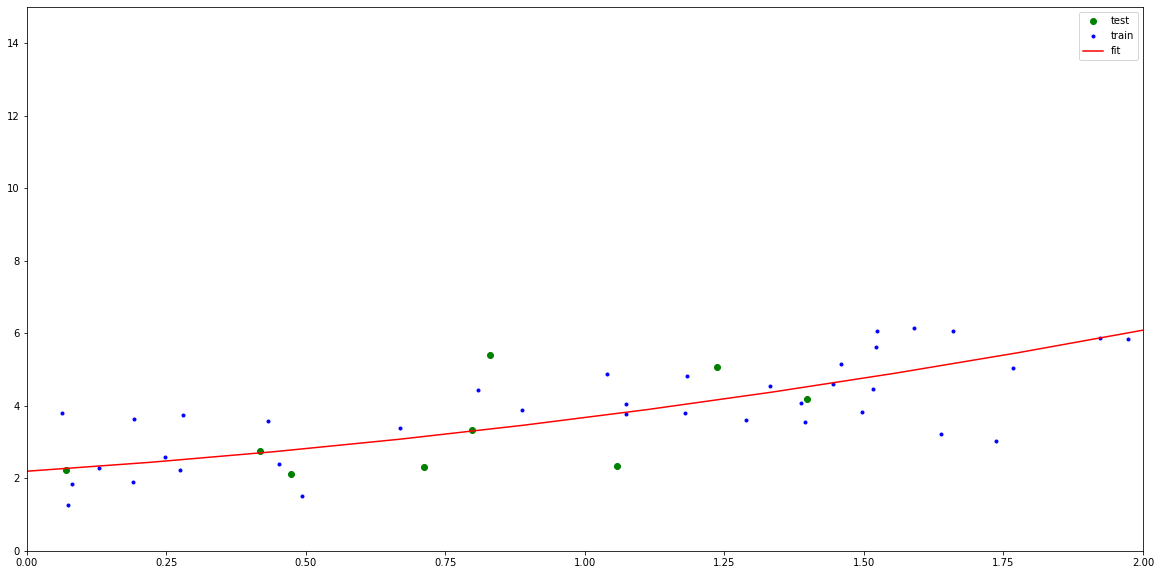

In [30]:
# plot train and test
plt.plot(X_new, y_new, "go", label='test')
plt.plot(X, y, "b.", label='train')

# plot the polynomial
xs = np.linspace(0, 2, 10)[:, np.newaxis]
ys = lin_reg.predict(poly_features.transform(xs))
plt.plot(xs, ys, "r-", label='fit')

plt.axis([0, 2, 0, 15])
plt.legend()
plt.show()

## Learning Corves <a class="anchor" id="learning_curves"></a>

In [31]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def split_sorted(X: np.ndarray, y: np.ndarray, test_size: float):
    idxs = np.argsort(X.reshape(-1))
    test_size = int(y.size*test_size)
    train_idxs = idxs[: -int(test_size)]
    test_idxs = np.setdiff1d(np.arange(y.size), train_idxs)

    return X[train_idxs], X[test_idxs], y[train_idxs], y[test_idxs]
    

def plot_learning_curves(model, X, y, split_sort: bool = False):
    # split to train and test
    if split_sort:
        X_train, X_val, y_train, y_val = split_sorted(X, y, test_size=0.2)
    else:
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    
    train_errors, val_errors = [], []
    
    # increase the train sequentialy 
    for m in range(1, len(X_train) + 1):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    
    fig, axes = plt.subplots(ncols=2)
    
    axes[0].plot(X_train, y_train, "r.", label="train")
    axes[0].plot(X_val, y_val, "bo", label="validation")
    xs = np.linspace(min(X),max(X),100)
    ys = model.predict(xs)
    axes[0].plot(xs, ys, "g-", label="fit")
    axes[0].legend(loc="upper right", fontsize=14)   

    
    axes[1].plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    axes[1].plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    axes[1].legend(loc="upper right", fontsize=14)   
    axes[1].set_xlabel("Training set size", fontsize=14)
    axes[1].set_xlabel("RMSE", fontsize=14)              

### Linear fit

(0.0, 80.0, 0.0, 10.0)

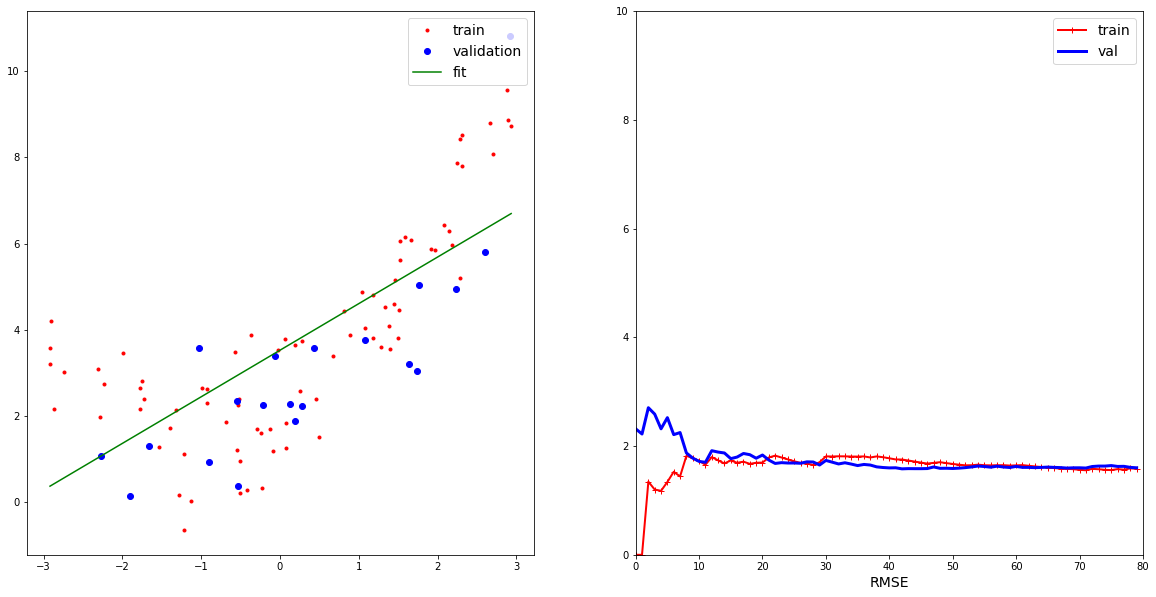

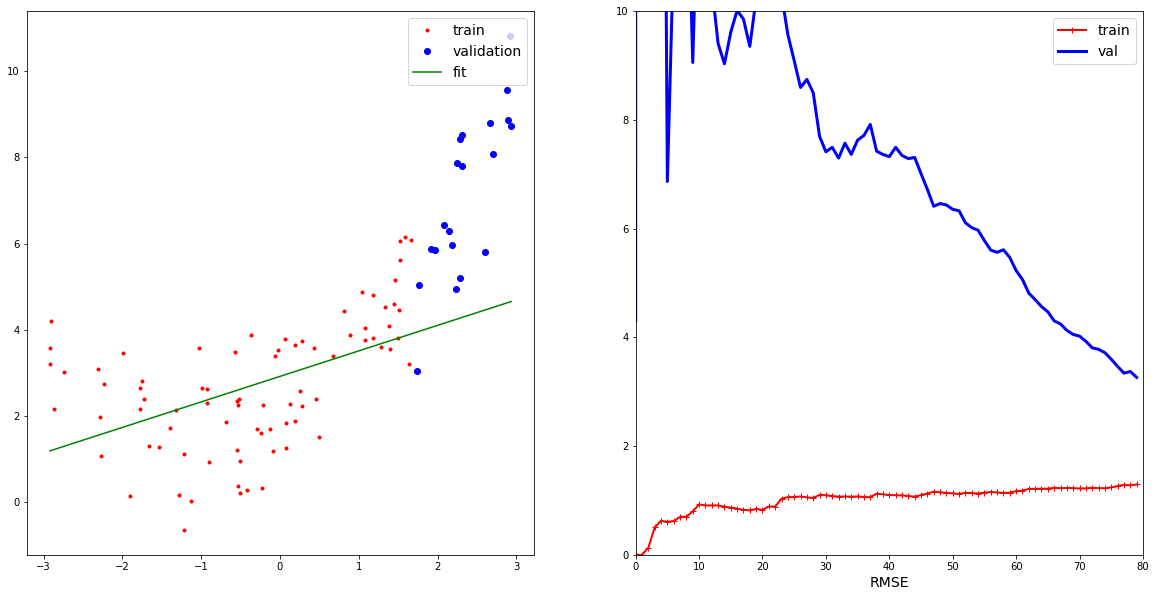

In [32]:
## Poor fit 
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y, split_sort=False)
plt.axis([0, 80, 0, 10])                         
plot_learning_curves(lin_reg, X, y, split_sort=True)
plt.axis([0, 80, 0, 10])                         



## High Degree Polynomial

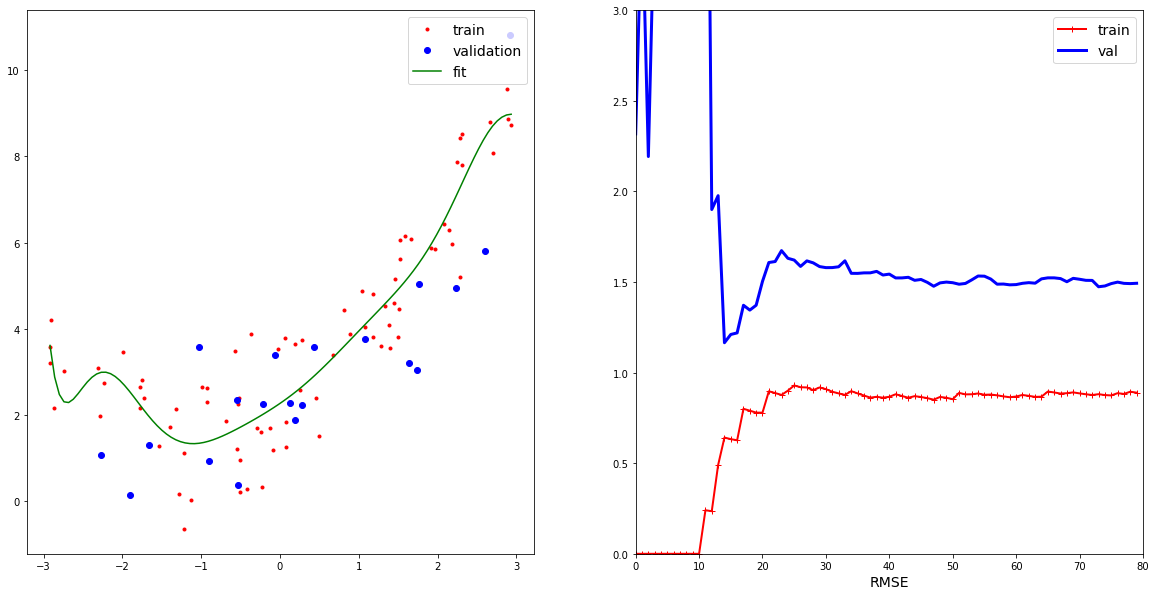

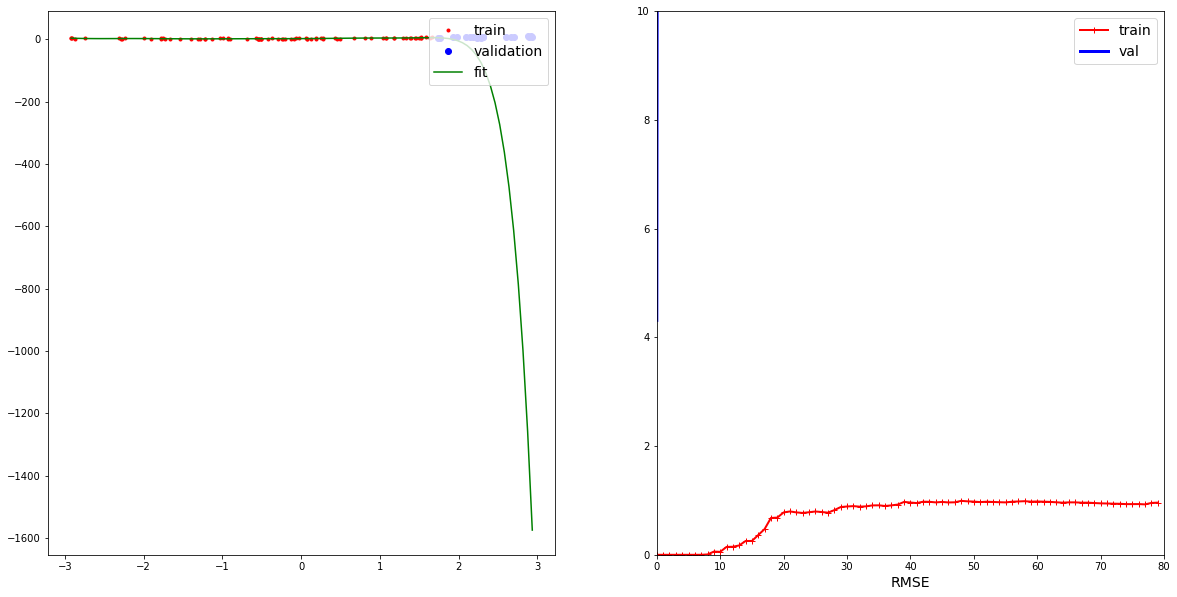

In [34]:
from sklearn.pipeline import Pipeline

# question - what will happen if we include bias in PolynomialFeatures
# Answer - nothing we will have two biases as LinearRegression adds one too - so one will just be redundant
polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])
plot_learning_curves(polynomial_regression, X, y, split_sort=False)
plt.axis([0, 80, 0, 3])           
plot_learning_curves(polynomial_regression, X, y, split_sort=True)
plt.axis([0, 80, 0, 10])           
plt.show()  

### Two degree polynomial (correct)

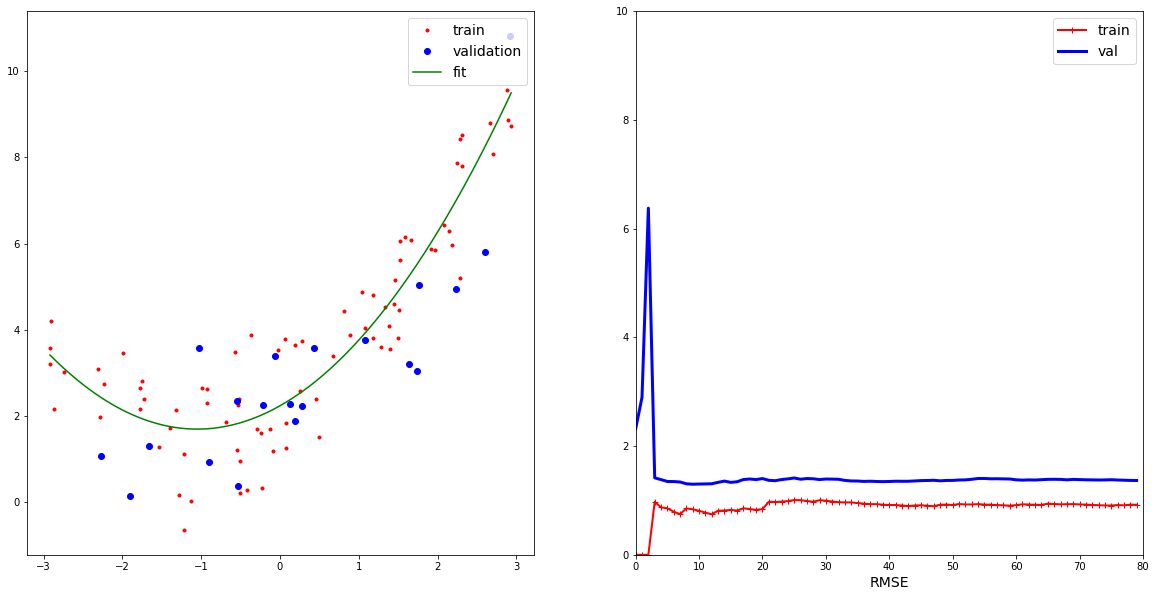

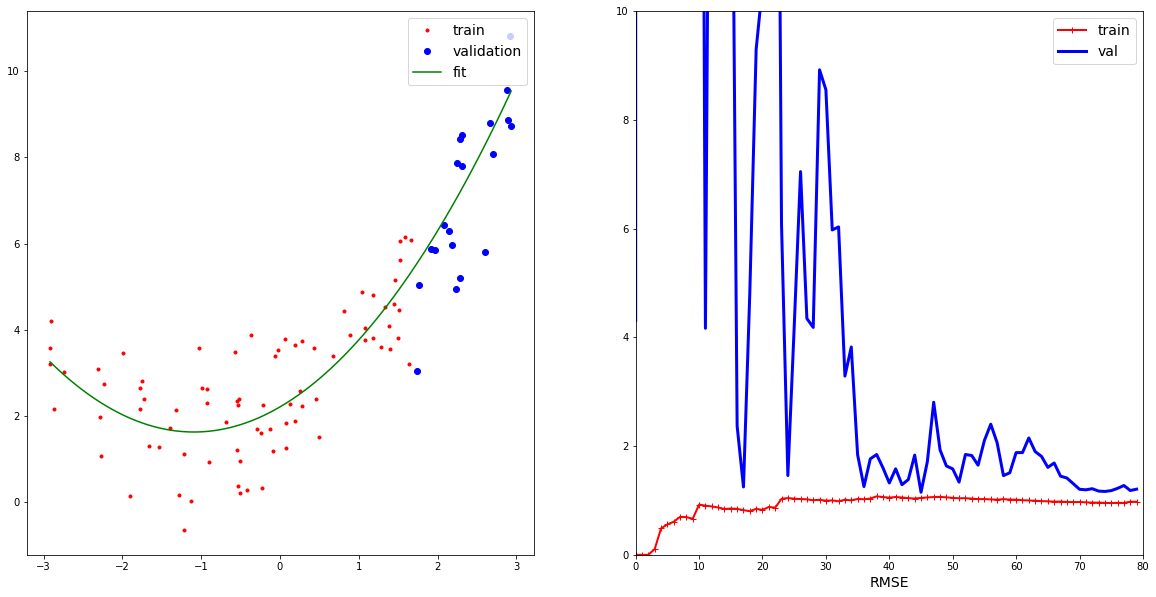

In [35]:
from sklearn.pipeline import Pipeline

# question - what will happen if we include bias in PolynomialFeatures
polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y, split_sort=False)
plt.axis([0, 80, 0, 10])           # not shown
plot_learning_curves(polynomial_regression, X, y, split_sort=True)
plt.axis([0, 80, 0, 10])           # not shown
plt.show()  

## Regularized regression <a class="anchor" id="regularization"></a>

### Ridge <a class="anchor" id="ridge_lasso_elastic"></a>

In [36]:
# this is legacy
# np.random.seed(42)

from numpy.random import RandomState
rs = RandomState(42)

m = 20
X = 3 * rs.rand(m, 1)
y = 1 + 0.5 * X + rs.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)


In [37]:
# using Cholesky matrix factorization
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [38]:
# using stochastic gradient descent 
from sklearn.linear_model import SGDRegressor
# ridge = l2 penalty
sgd_reg = SGDRegressor(penalty="l2", max_iter=1000, tol=1e-3, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.47012588])

### Using different regularization parameter 

In [39]:
# Utility function
def plot_model(model_class: Callable, polynomial: bool, alphas: List[float], **model_kargs: Dict):
    
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        # define the model
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        
        if polynomial:
            model = Pipeline([
                    # extend the features 
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    # standardize the features
                    ("std_scaler", StandardScaler()),
                    # the model
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])


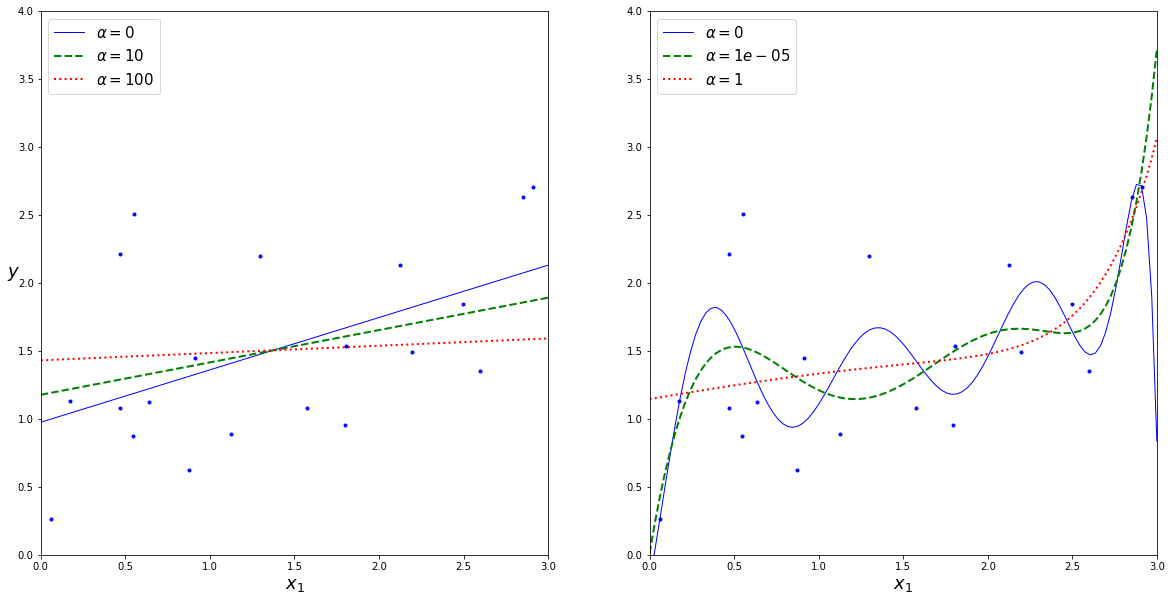

In [40]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# setting the size of the figure 
# plt.figure(figsize=(8,4))

# 1 row 2 columns - position in index 1 (upper left)
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
# 1 row 2 columns - position in index 2
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

plt.show()

### Lasso

In [ ]:
from sklearn.linear_model import Lasso

# plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

In [ ]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

### Elatic Net

In [ ]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

## Early Stopping <a class="anchor" id="early_stopping"></a>

In [ ]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)


In [ ]:
from copy import deepcopy

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

# configure for one iteration only - so we can do it outside 
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)
print('best model')
print(best_model.coef_, best_model.intercept_)

In [ ]:
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
